In [167]:
import pandas 
import numpy as np
from sklearn.model_selection import train_test_split
from keras import models, layers,regularizers
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt


In [168]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed


In [6]:
# def focal_loss(gamma=2., alpha=.25):
#     def focal_loss_fixed(y_true, y_pred):
#         pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#         pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

#         pt_1 = K.clip(pt_1, 1e-3, .999)
#         pt_0 = K.clip(pt_0, 1e-3, .999)

#         return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
#     return focal_loss_fixed

In [169]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


In [170]:
train_path = '../input/train.csv'
train = pandas.read_csv(train_path)

test_path = '../input/test.csv'
test = pandas.read_csv(test_path)

y = train.target
train = train.drop('target',axis = 1)
ID_code = train.ID_code
train = train.drop('ID_code',axis=1)

ID_code = test.ID_code
test = test.drop('ID_code',axis=1)

In [171]:
train.shape

(200000, 200)

In [172]:
train.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [173]:
train.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,6.618800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,7.629600,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,8.584425,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,11.150600,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [ ]:
mean = train.mean()
std = train.std()
mean,std

(var_0      10.679914
 var_1      -1.627622
 var_2      10.715192
 var_3       6.796529
 var_4      11.078333
 var_5      -5.065317
 var_6       5.408949
 var_7      16.545850
 var_8       0.284162
 var_9       7.567236
 var_10      0.394340
 var_11     -3.245596
 var_12     14.023978
 var_13      8.530232
 var_14      7.537606
 var_15     14.573126
 var_16      9.333264
 var_17     -5.696731
 var_18     15.244013
 var_19     12.438567
 var_20     13.290894
 var_21     17.257883
 var_22      4.305430
 var_23      3.019540
 var_24     10.584400
 var_25     13.667496
 var_26     -4.055133
 var_27     -1.137908
 var_28      5.532980
 var_29      5.053874
              ...    
 var_170    -0.004962
 var_171    -0.831777
 var_172    19.817094
 var_173    -0.677967
 var_174    20.210677
 var_175    11.640613
 var_176    -2.799585
 var_177    11.882933
 var_178    -1.014064
 var_179     2.591444
 var_180    -2.741666
 var_181    10.085518
 var_182     0.719109
 var_183     8.769088
 var_184  

In [ ]:
train =  (train-mean)/std

In [ ]:
test =  (test-mean)/std

In [ ]:
X_val = train[:10000]
y_val = y[:10000]
X = train[10000:]
y = y[10000:]


In [ ]:
X.shape

(190000, 200)

In [ ]:
model  = models.Sequential()
model.add(layers.Dense(10, activation='relu',input_shape=(200,)))
model.add(layers.Dense(20, activation='relu',))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model.add(layers.Dense(1, activation='sigmoid'))


In [ ]:
model.compile(optimizer='rmsprop',loss =[focal_loss(alpha=.5, gamma=2)],metrics=['binary_accuracy',f1])

In [ ]:
history=model.fit(X,y,
                  epochs=20,
                  batch_size=1000,
                  validation_data=(X_val,y_val),
                 class_weight = {0 : 1., 1: 20.}
)

In [198]:
print(history.history.keys())


dict_keys(['val_loss', 'val_binary_accuracy', 'val_f1', 'loss', 'binary_accuracy', 'f1'])


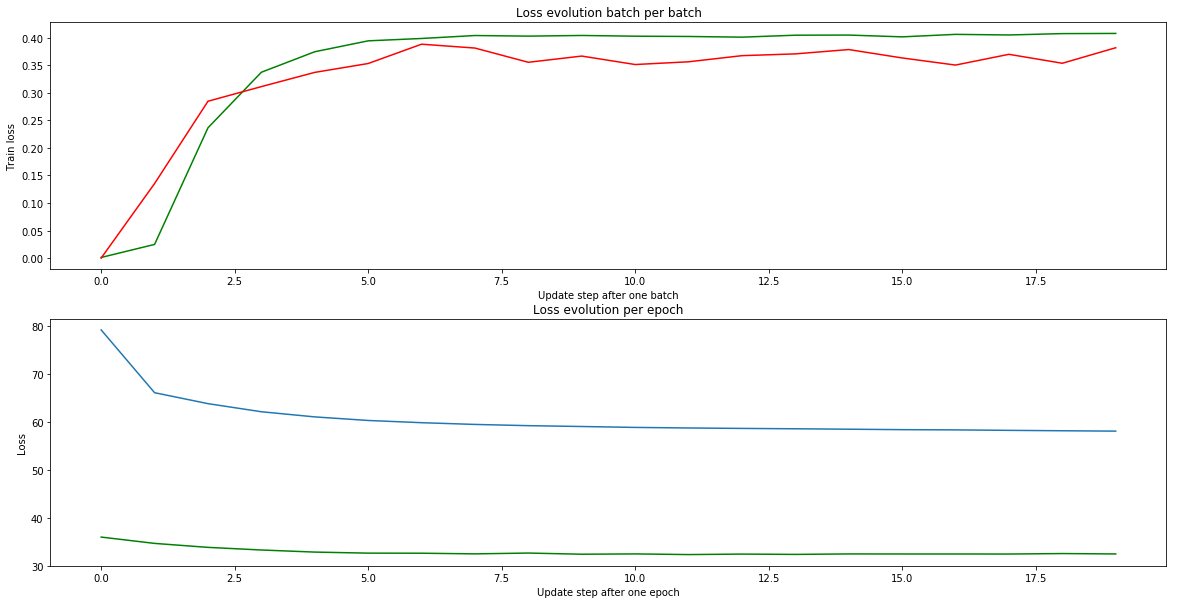

In [139]:

fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(history.history['f1'], color="Green")
ax[0].plot(history.history['val_f1'], color="Red")
ax[0].set_xlabel("Update step after one batch")
ax[0].set_ylabel("Train loss")
ax[0].set_title("Loss evolution batch per batch")
ax[1].plot(history.history["val_loss"], color="Green")
ax[1].plot(history.history["loss"])
ax[1].set_title("Loss evolution per epoch")
ax[1].set_xlabel("Update step after one epoch")
ax[1].set_ylabel("Loss")
fig.savefig("losses_improved_model", format="eps")

In [140]:
val_pred = model.predict(X_val)

Text(0.5, 0, 'Predicted probabilites')

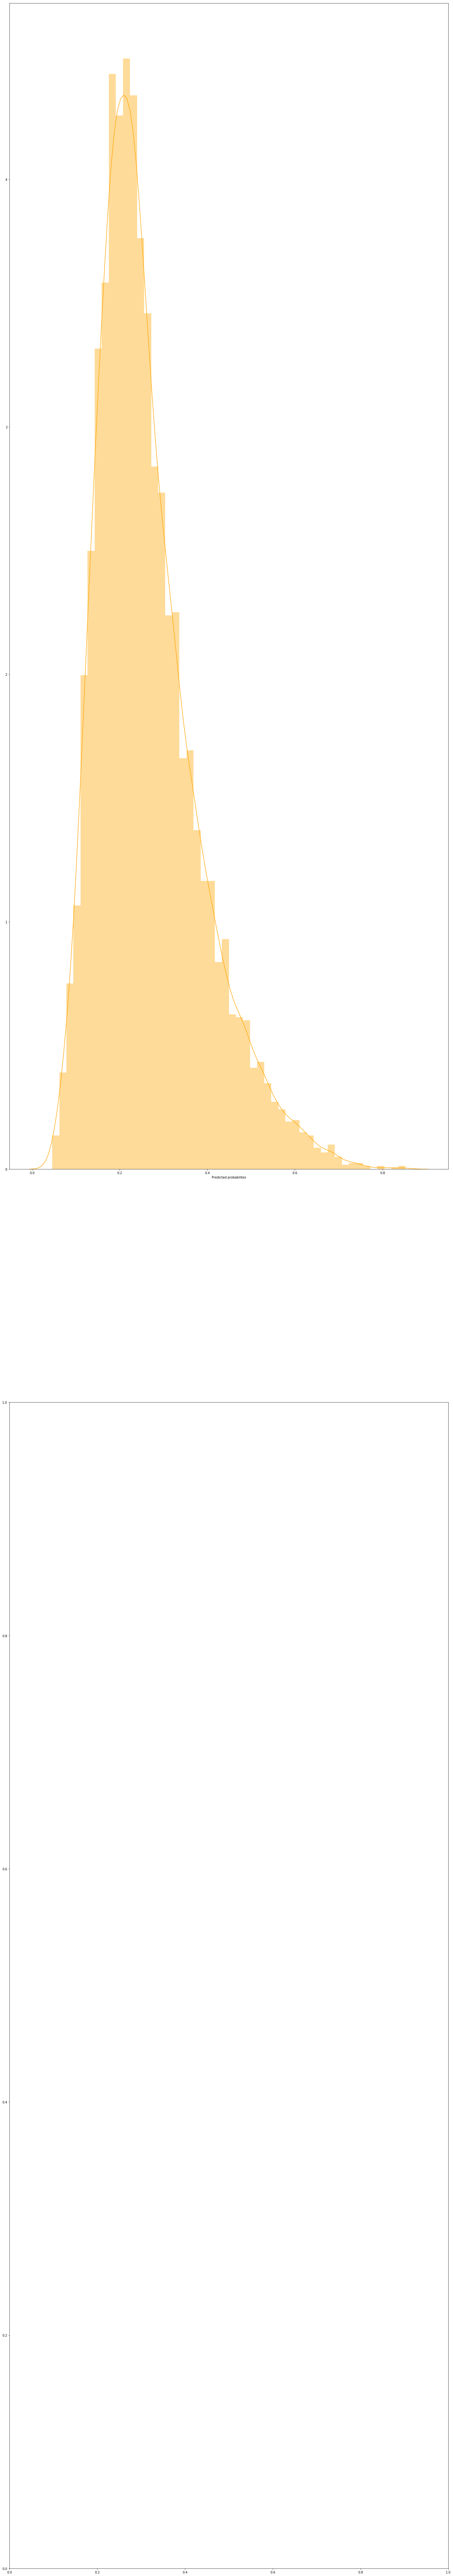

In [141]:
import seaborn as sns
fig, ax = plt.subplots(2,1,figsize=(25,150))
sns.distplot(val_pred, color="Orange", ax=ax[0])
ax[0].set_xlabel("Predicted probabilites")
# sns.distplot(improved_proba_predictions.values[:,1], color="Purple", ax=ax[1])
# ax[1].set_xlabel("Predicted probabilites of {}".format(improved_proba_predictions.columns.values[1]))
# ax[1]

100%|██████████| 1000/1000 [00:02<00:00, 375.44it/s]


Probability threshold maximizing CV F1-score for each class:
[0.321] 0.7668745093255513


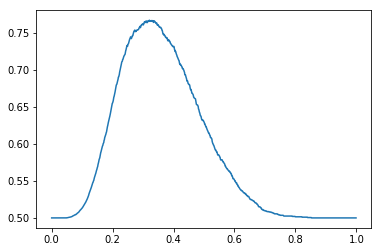

In [142]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

rng = np.arange(0, 1, 0.001)
f1s = np.zeros((rng.shape[0]))
for j,t in enumerate(tqdm(rng)):
    p = np.array(val_pred>t, dtype=np.int8)
    scoref1 = roc_auc_score(y_val, p)
    f1s[j] = scoref1

    
plt.plot(rng, f1s)
T = rng[np.where(f1s == np.max(f1s))[0]]
print('Probability threshold maximizing CV F1-score for each class:')
print(T, np.max(f1s))

Probability threshold maximizing CV F1-score for each class:
[0.398] 0.7632878103620613


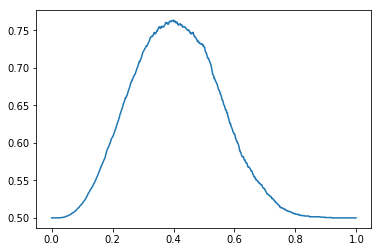

In [104]:
predictions = model.predict(test)

In [262]:
answers = (predictions.flatten()>T).astype(int)

In [105]:
res=pandas.DataFrame({'ID_code':list(ID_code),'target':predictions.flatten()})

In [106]:
res.to_csv("answer_nn_pred_focal_loss_075_2_weighted_class.csv",index=False)

In [180]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f answer_nn_pred_focal_loss_075_2_weighted_class.csv -m " keras 2 layers weightd classes focal loss 0.75 2"

100%|██████████████████████████████████████| 4.22M/4.22M [00:03<00:00, 1.13MB/s]
Successfully submitted to Santander Customer Transaction Prediction